Let's first load some libraries...

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

#**IMDB Dataset**

We load the IMDB dataset. Each of the terms is represented in the data by a unique integer in the range between 0 and 88,586. Each observation in the train or test data is therefore just a list of integer values. The associated labels are binary indicators of positive or negative rating valence values. IMDB ratings are out of 10, so I presume positive means something like 8+, and negative means something like < 8.  

In [3]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(index_from=3)

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The observation in the training data with the largest number of 'frequent' terms has ~2,500 of them. If we extract the largest integer value across each review in the data, put it into a list, and then take the max of that list, we see the largest integer index is 88,586 (the highest index token).

In [5]:
print(max(len(i) for i in train_data))
print(max([max(sequence) for sequence in train_data]))

2494
88586


We can reverse the integer coding like this...

In [6]:
# Here is the key-value dictionary that stores the integer indexes for each term.
# Note that the word index dictionary has 'garbage' values in the first three entries.
# These are explained in the dataset description if you look for it; they are special terms in the data.
word_index = imdb.get_word_index()

# So, the word 'big' is represented by integer 191.
print(word_index.get("the"))

# We can reverse the keys and values for each entry, to get a dictionary that would let us 'decode' the terms from a review.
#reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
adjusted_reverse_word_index = {index + 3: word for word, index in word_index.items()}
adjusted_reverse_word_index["<PAD>"] = 0
adjusted_reverse_word_index["<START>"] = 1
adjusted_reverse_word_index["<UNK>"] = 2
adjusted_reverse_word_index["<UNUSED>"] = 3

print(adjusted_reverse_word_index)

# Now we can convert integer values back to terms for a given review in the sample.
decoded_review = " ".join([adjusted_reverse_word_index.get(i,'?') for i in train_data[0]])
print(train_data[0])
print(decoded_review)

1
{34704: 'fawn', 52009: 'tsukino', 52010: 'nunnery', 16819: 'sonja', 63954: 'vani', 1411: 'woods', 16118: 'spiders', 2348: 'hanging', 2292: 'woody', 52011: 'trawling', 52012: "hold's", 11310: 'comically', 40833: 'localized', 30571: 'disobeying', 52013: "'royale", 40834: "harpo's", 52014: 'canet', 19316: 'aileen', 52015: 'acurately', 52016: "diplomat's", 25245: 'rickman', 6749: 'arranged', 52017: 'rumbustious', 52018: 'familiarness', 52019: "spider'", 68807: 'hahahah', 52020: "wood'", 40836: 'transvestism', 34705: "hangin'", 2341: 'bringing', 40837: 'seamier', 34706: 'wooded', 52021: 'bravora', 16820: 'grueling', 1639: 'wooden', 16821: 'wednesday', 52022: "'prix", 34707: 'altagracia', 52023: 'circuitry', 11588: 'crotch', 57769: 'busybody', 52024: "tart'n'tangy", 14132: 'burgade', 52026: 'thrace', 11041: "tom's", 52028: 'snuggles', 29117: 'francesco', 52030: 'complainers', 52128: 'templarios', 40838: '272', 52031: '273', 52133: 'zaniacs', 34709: '275', 27634: 'consenting', 40839: 'snugg

In [7]:
len(train_data[0])

218

#*Pre-processing the Data*

Now, we need to pre-process the data. We can't just pass integer lists of variable length into the neural network. We need a fixed number of features to serve as our x's (inputs) to the network, i.e., same number of features for each observation in the training data (and also the test data for validation, later). The most obvious thing we can do is multi-hot encode the observations (i.e., dummy code it). So, we basically make a matrix with 85,000+ columns, and set values to 1 for columns representing the words that are present and 0 for columns representing the words that are not present in a review.

*Q: Why can't we just feed in the raw lists of integers as our input? What's the problem?*

In [9]:
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) # we will work with top 10k most frequent terms.

def vectorize_sequences(sequences, dimension=10000):

    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), dimension))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

# I am converting the resulting giant arrays into float datatype. They are 'float64' by default, which takes more RAM.
x_train = vectorize_sequences(train_data).astype('float')
x_test = vectorize_sequences(test_data).astype('float')

# Labels are already fine, but we can convert them to floats to match the x's data type (they are 'float32' by default.)
y_train = train_labels.astype('float')
y_test = test_labels.astype('float')

We can see that the hot-encoding looks correct:

In [10]:
print(train_data[0])
print(x_train[0,14])
print(x_train[0,22])
print(x_train[0,23])
print(x_train.shape)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1.0
1.0
0.0
(25000, 10000)


#*Building the Model*

So, mapping binary inputs to binary outputs is a very simple problem setup. We don't even need to whiten the data; features are already in the 0-1 range. We will follow the book's advice and make a bunch of dense layers with relu activations, followed by a sigmoid activated output layer.

In [11]:
# Can install the tensorflow-addons package in your colab runtime.
try:
    import tensorflow_addons as tfa
except ImportError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Some options for mitigating over-fitting:
#   - Weight regularization.
#   - Activation regularization.
#   - Weight constraints.
#   - Dropout
#   - Topology simplification
#   - Add noise to the input data.

model = keras.Sequential([
    layers.Dropout(0.5), # This layer sets a random fraction of weights to 0 in a given training pass.
    layers.GaussianNoise(0.1), # This layer adds random normal noise to the input features.
    tfa.layers.NoisyDense(16,activation="relu"), # This injects noise into the weights at each step.
    layers.Dense(16, activation="relu",kernel_regularizer='l2'),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu",activity_regularizer='l2'),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# We will keep records 0-9,999 for validation, and we will use the remaining records for training.
# We are still holding out the test dataset by the way, so we are going to do train -> validation to figure out when overfitting happens.
# Then we are going to re-train on the whole training dataset with early stopping. Finally, we will evaluate performance on the test dataset.
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


118/118 [==============================] - 7s 20ms/step - loss: 0.7539 - accuracy: 0.6328 - val_loss: 0.6090 - val_accuracy: 0.8491
Epoch 2/20
118/118 [==============================] - 1s 9ms/step - loss: 0.6137 - accuracy: 0.7471 - val_loss: 0.5035 - val_accuracy: 0.8660
Epoch 3/20
118/118 [==============================] - 1s 9ms/step - loss: 0.5480 - accuracy: 0.7787 - val_loss: 0.4322 - val_accuracy: 0.8703
Epoch 4/20
118/118 [==============================] - 1s 9ms/step - loss: 0.5213 - accuracy: 0.7846 - val_loss: 0.4082 - val_accuracy: 0.8747
Epoch 5/20
118/118 [==============================] - 1s 9ms/step - loss: 0.4966 - accuracy: 0.7957 - val_loss: 0.4004 - val_accuracy: 0.8779
Epoch 6/20
118/118 [==============================] - 1s 12ms/step - loss: 0.4771 - accuracy: 0.8077 - val_loss: 0.3782 - val_accuracy: 0.8816
Epoch 7/20
118/118 [==============================] - 1s 12ms/step - loss: 0.4685 - accuracy: 0.8069 - val_loss: 0.3598 - val_accuracy: 0.8752
Epoch 8/20
118

As you can see, the model starts to overfit after 3-4 epochs; validation accuracy starts to decline. Here we are plotting loss...

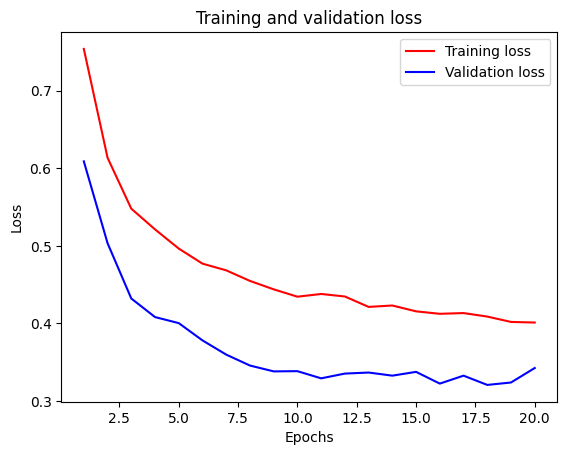

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Here we are plotting accuracy.

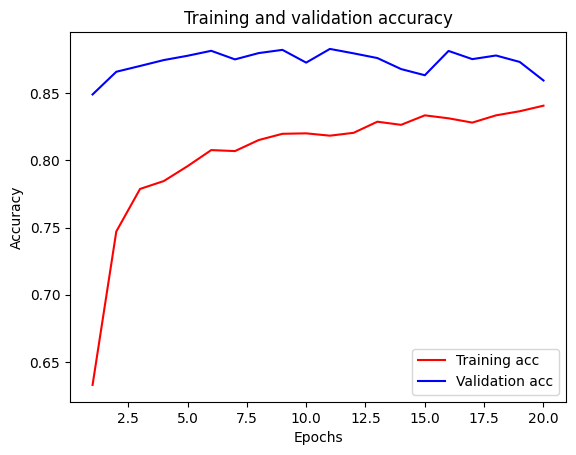

In [14]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Note: if you see your RAM creeping up, you might want to clear some things out of memory to free up space... the garbage collector can help here. I'm going to delete the existing model and the original test / train datasets (we have them in hot-encoded format now anyway. Or, you can set the objects to 0.

In [15]:
import gc
del model, train_data, test_data
gc.collect()

# Setting the objects to empty can also help.
train_data, test_data = [],[]

Let's re-run this and force a stop after 4 epochs. Note, you need to redefine the model here, else it will just pickup where your model left off (i.e., the last set of weights you were using, which are already overfit).



In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=512,
                    validation_data=(x_test, y_test))

# This will return our loss and accuracy metrics.
model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 9s 96ms/step - loss: 0.5001 - accuracy: 0.7820 - val_loss: 0.3420 - val_accuracy: 0.8776
Epoch 2/4
49/49 [==============================] - 1s 27ms/step - loss: 0.2492 - accuracy: 0.9118 - val_loss: 0.2890 - val_accuracy: 0.8845
Epoch 3/4
49/49 [==============================] - 1s 26ms/step - loss: 0.1763 - accuracy: 0.9373 - val_loss: 0.2988 - val_accuracy: 0.8820
Epoch 4/4
49/49 [==============================] - 1s 26ms/step - loss: 0.1396 - accuracy: 0.9521 - val_loss: 0.3213 - val_accuracy: 0.8780


And, of course, the model is useless if we can't use it to produce a new prediction. So, let's do that as well.

In [ ]:
import pandas as pd

# y_test is a 1D numpy array, whereas our predictions are a 2D array.
print(y_test.shape)

predictions = model.predict(x_test)
print(predictions.shape)

# np.ravel() is another way to flatten an array into 1D, so then we can take the cross-tabulation.
# Note that I'm applying the >0.5 threshold rule to the predictions.
pd.crosstab(np.ravel(predictions)>0.5,y_test)

(25000,)
(25000, 1)


col_0    0.0    1.0
row_0              
False  11016   1512
True    1484  10988